## Understanding the Change in Reconstructed Track Parameters: 32-bit vs 64-bit Builds

With this study we would like to understand the difference in the tracks and
their parameters when comparing reconstruction with 32- and 64-bit libraries. 
Due to an expected small difference between the floating point numbers calculations
in 32- and 64-bit environments any *unstable* function can result in undesirable divergence of the parameters. An *unstable* function would produce a significantly different output even for small changes in the input. 

We established that calls to `StiKalmanTrackNode::propagateMCS()` lead to differences in reconstructed track parameters.

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import star.phys as phys
import star.tpc as tpc
import star.utils as stu

## Data

The track parameters are: $x$, $y$, $z$, $\phi$, $P_T$, $\tan(\Lambda)$

In [2]:
rootfile = 'data/install-star-cvs-master-gcc485-root5_def-32/io_propagateMCS.root'
branches = ['po', 'pp']

var_names = ['x', 'y', 'z', 'phi', 'pt', 'tan']
var_types = ['o', 'p']
columns = [ t + '_' + n for t in var_types for n in var_names]
#print(columns)

Read the track parameter values from the input file.

In [3]:
%%time
df, _ = stu.make_df(rootfile, 't', branches, {})
df.columns = columns

#df.info()

CPU times: user 547 ms, sys: 194 ms, total: 741 ms
Wall time: 1.12 s


Calculate the absolute and relative differences between the original and modified values as calculated by `StiKalmanTrackNode::propagateMCS()`

In [4]:
mydict = { f'd_{n}': df[f'o_{n}'] - df[f'p_{n}'] for n in var_names }
df = df.assign(**mydict)

mydict = { f'r_{n}': (df[f'o_{n}'] - df[f'p_{n}'])/df[f'o_{n}'] for n in var_names }
df = df.assign(**mydict)

#df.info()

## Plot the change in track parameters

### Absolute change

Plot the difference for every track parameter.

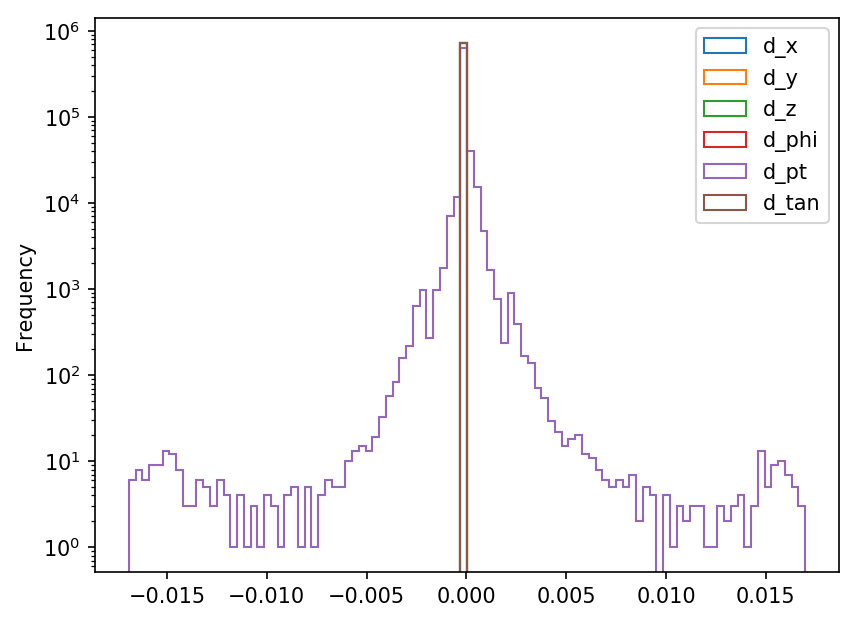

In [5]:
h = df.plot(y=[ f'd_{v}' for v in var_names], kind='hist', histtype='step', bins=100, logy=True)

It looks like only the $P_T$ is modified by the `propagateMCS` function. So, let's see how its change correlates with the original value.

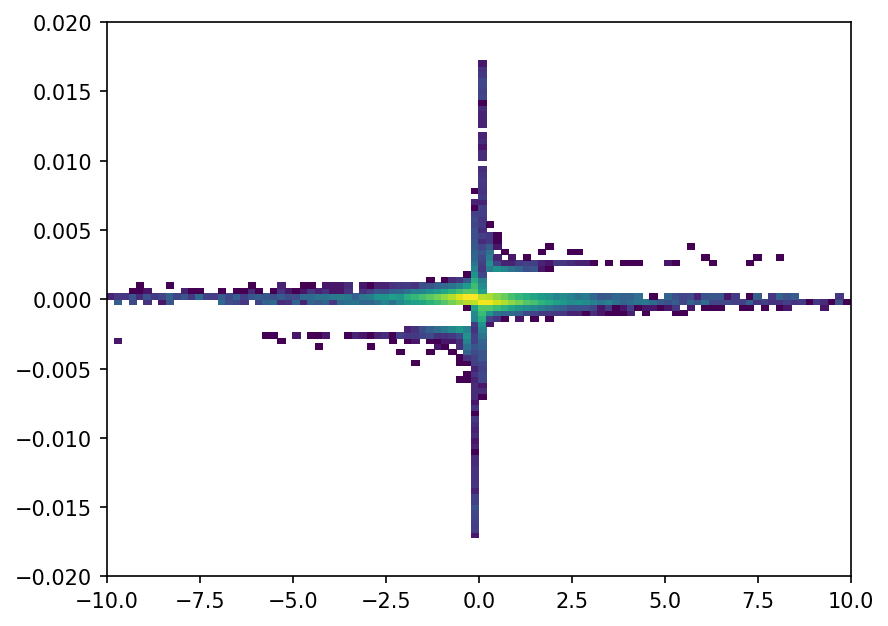

In [6]:
bins=[np.linspace(-10, 10, 101), np.linspace(-0.02, 0.02, 101)]
h = plt.hist2d(df.o_pt, df.d_pt, bins=bins, norm=mpl.colors.LogNorm())

The zoom-in version of the above plot:

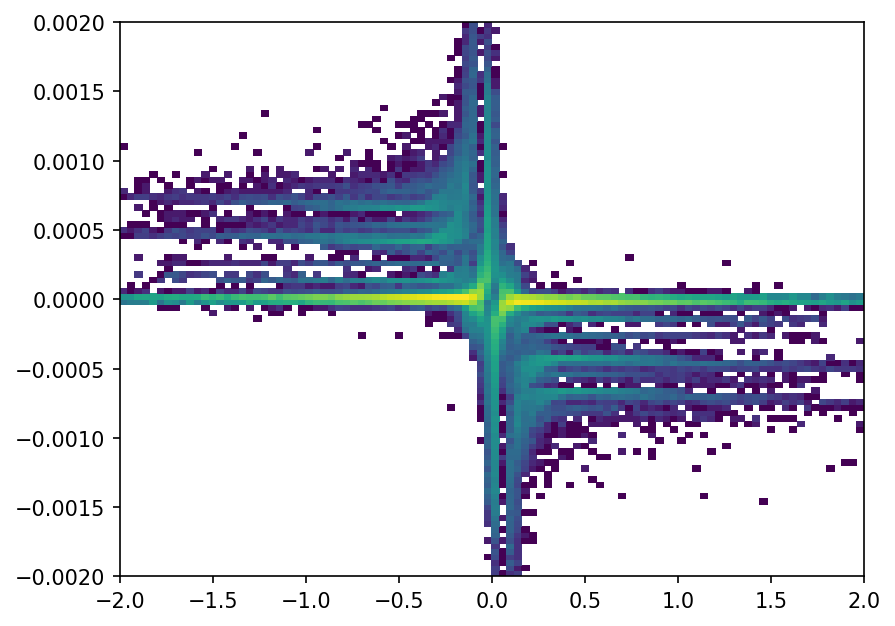

In [7]:
bins=[np.linspace(-2, 2, 101), np.linspace(-0.002, 0.002, 101)]
h = plt.hist2d(df.o_pt, df.d_pt, bins=bins, norm=mpl.colors.LogNorm())

It is harder to interpret the absolute change in the $P_T$ therefore let's look at the relative one.

### Relative change in $P_T$ w.r.t. original value

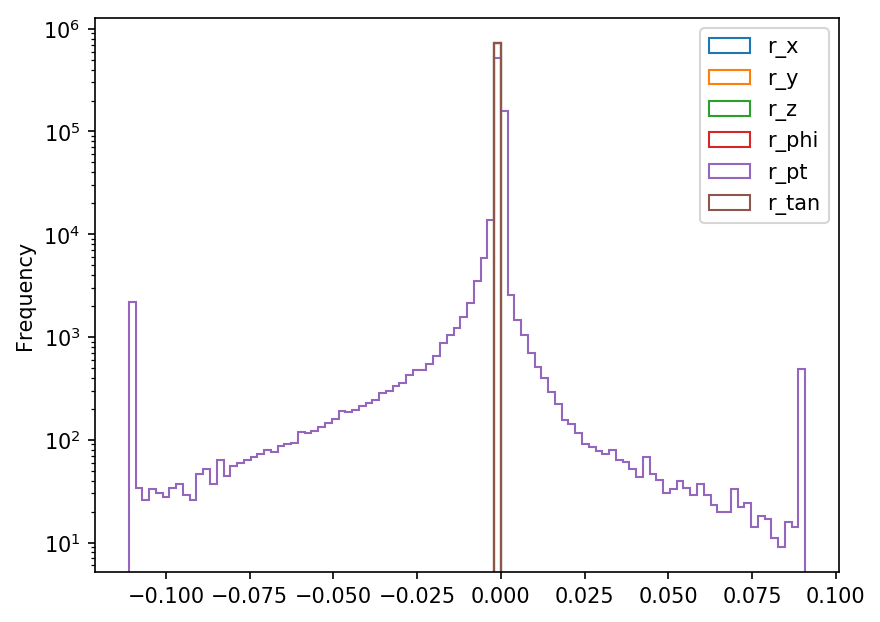

In [8]:
h = df.plot(y=[ f'r_{v}' for v in var_names], kind='hist', histtype='step', bins=100, logy=True)

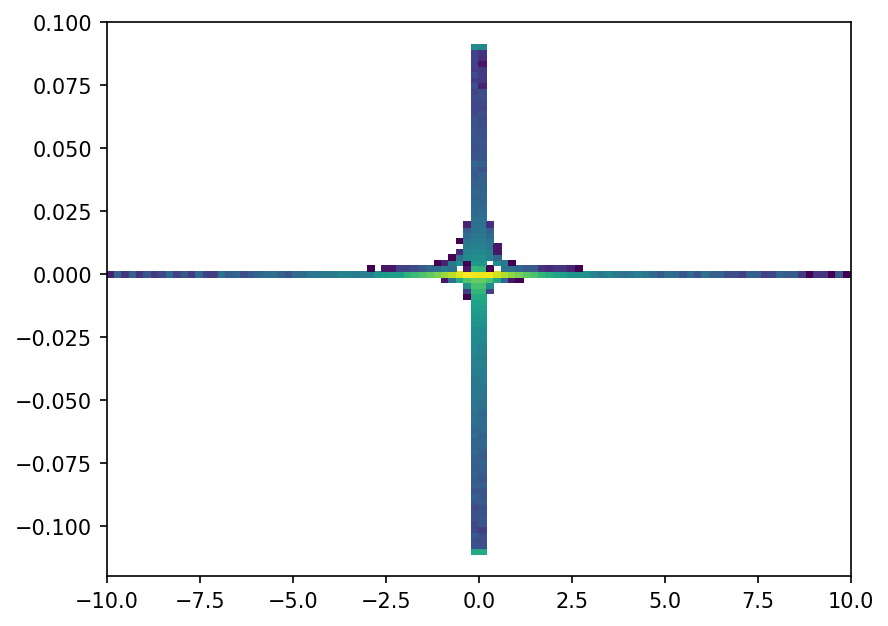

In [9]:
bins=[np.linspace(-10, 10, 101), np.linspace(-0.12, 0.1, 101)]
h = plt.hist2d(df.o_pt, df.r_pt, bins=bins, norm=mpl.colors.LogNorm())

The zoom-in version of the above plot:

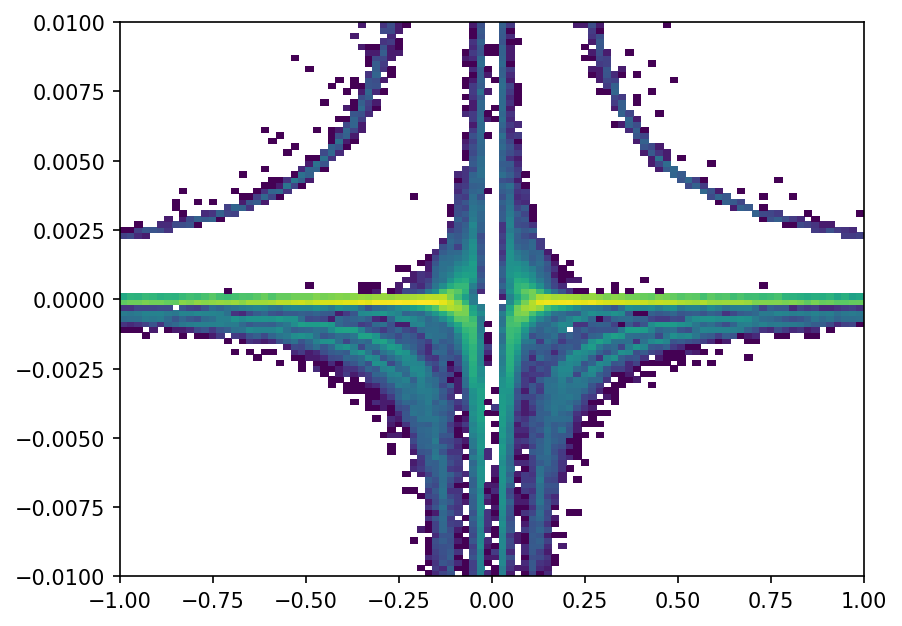

In [10]:
bins=[np.linspace(-1, 1, 101), np.linspace(-0.01, 0.01, 101)]
h = plt.hist2d(df.o_pt, df.r_pt, bins=bins, norm=mpl.colors.LogNorm())

Absolute $P_T$ values below 200 MeV

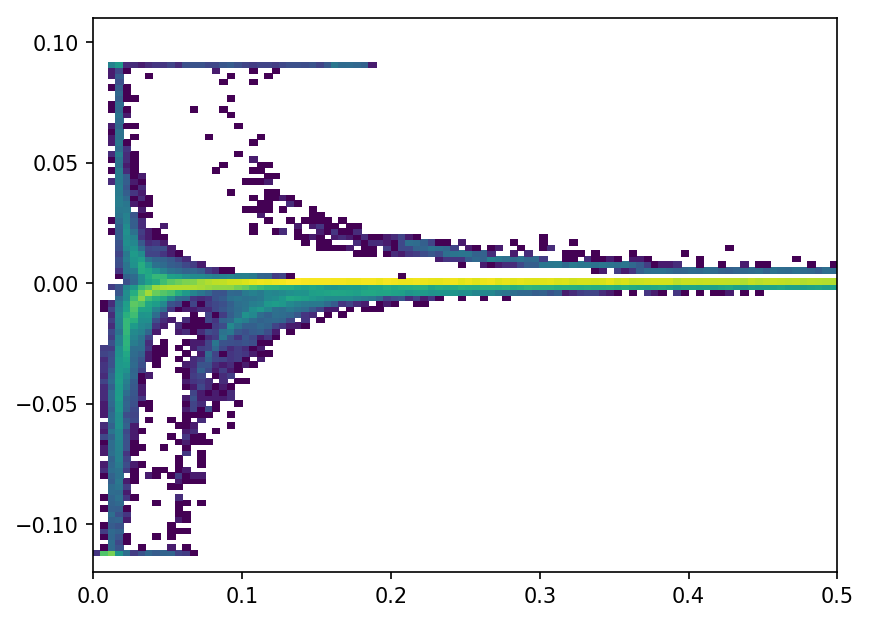

In [11]:
bins=[np.linspace(0, 0.5, 101), np.linspace(-0.12, 0.11, 101)]
h = plt.hist2d(np.abs(df.o_pt), df.r_pt, bins=bins, norm=mpl.colors.LogNorm())

## Summary

- Only $P_T$ of the track is modified by the `StiKalmanTrackNode::propagateMCS()` function
- The track $P_T$ values do not change by more than 10%
- $P_T$ values above 200 MeV are modified by less than ~1%

From the above plots one could try to set a regularization cut on $P_T$ values at 100 MeV. This might help to make this function more stable.

**Note:** A more correct way to look at the effect of this function is by considering individual tracks rather than looking at uncorrelated energy losses. With individual tracks one could possibly see a large accumulated effect due to correlated energy loss calculations at every track node. 